<a href="https://colab.research.google.com/github/poojasaxena/tensorflow-developer-zertificate-coursera/blob/main/course2_convolutional-neural-networks-tensorflow/03_transfer-learning/Course_2_Part_6_Lesson_2_Notebook_Xception_catvsdogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1. Setup

In [4]:
%autosave 60

Autosaving every 60 seconds


In [5]:
import tensorflow as tf
from tensorflow.data import Dataset
print(tf.__version__)

2.6.0


In [6]:
import tensorflow_datasets as tfds

# Step 2. Getting the Data

Transfer learning is most useful when working with very small datasets. To keep our dataset small, we will use 40% of the original training data (25,000 images) for training, 10% for validation, and 10% for testing.



In [7]:
## To find all datasets with cat in them
[fn for fn in tfds.list_builders() if "cat" in fn]

2021-09-27 17:37:51.571015: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


['cats_vs_dogs',
 'd4rl_adroit_relocate',
 'visual_domain_decathlon',
 'huggingface:acronym_identification',
 'huggingface:catalonia_independence',
 'huggingface:interpress_news_category_tr']

In [5]:
tfds.load?

In [6]:
train_ds, validation_ds, test_ds= tfds.load(name="cats_vs_dogs", 
          ## Reserver 10% validation and 10% for test
          split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
          as_supervised=True
          )

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete8FUTVF/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [7]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


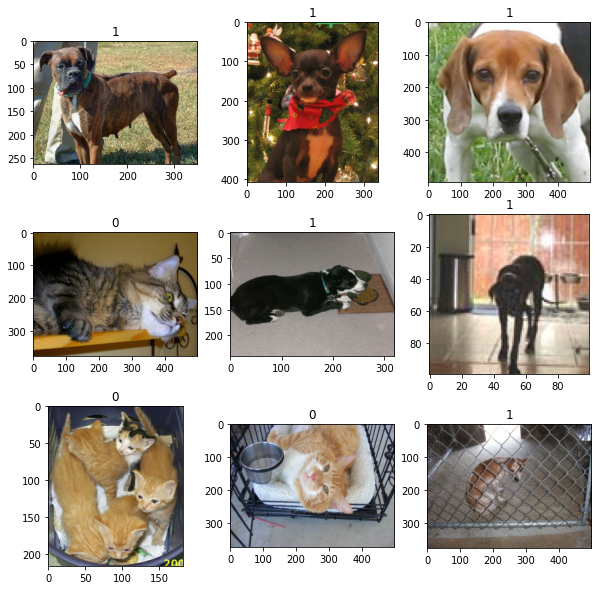

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis(True)



### Observation
1. We can see that label:0 is cat and label:1 is dog
2. the images are of different sizes., 300x350, 350x500 and so on.

### Standerdizing the data
Since our raw image have a variety of sizes. In addition, each pixel consists of 3 integer values betwen 0-255 (RGB level values). This isnt a great fit for feeding a neural network. 

We need to do two things:
1. Standerize to a fixed image sie, we pick 150x150
2. Normalize pixel values between -1 and 1

In general, it's a good practice to develop models that take raw data as input, as opposed to models that take already-preprocessed data. The reason being that, if your model expects preprocessed data, any time you export your model to use it elsewhere (in a web browser, in a mobile app), you'll need to reimplement the exact same preprocessing pipeline. This gets very tricky very quickly. So we should do the least possible amount of preprocessing before hitting the model.

Here, we'll do image resizing in the data pipeline (because a deep neural network can only process contiguous batches of data), and we'll do the input value scaling as part of the model, when we create it.

Let's resize images to 150x150:



In [14]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y : (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y : (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y : (tf.image.resize(x, size), y))

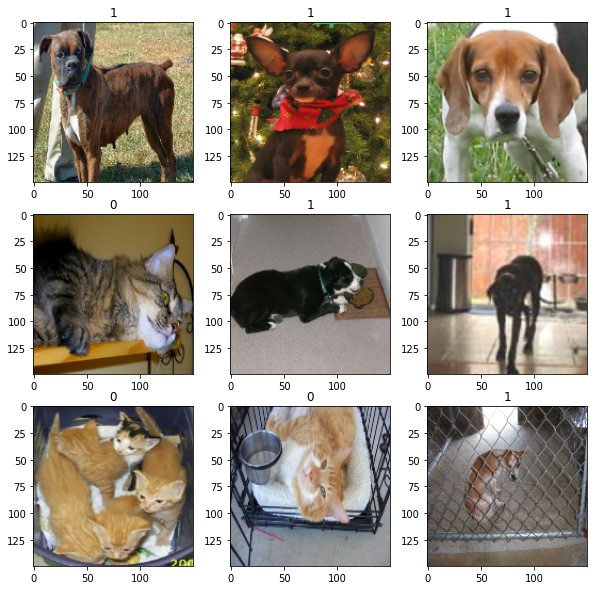

In [31]:
## Lets confirm if the size is resized to 150x150
plt.figure(figsize=(10,10))

for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image/255)
  plt.title(int(label))
  plt.axis(True)


### Prefetch

* Definition: Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

* Performance difference:
    1. The execution time spent normally
    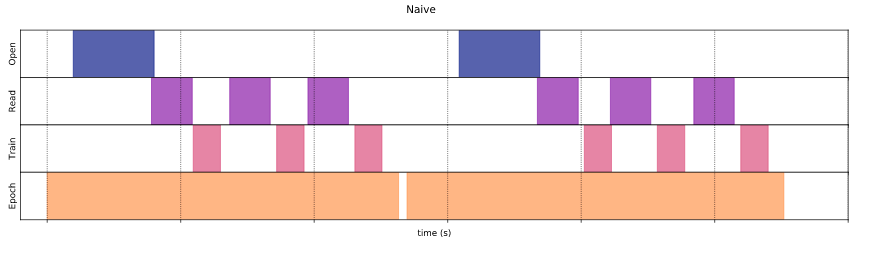
    2. Time spent after prefetch
    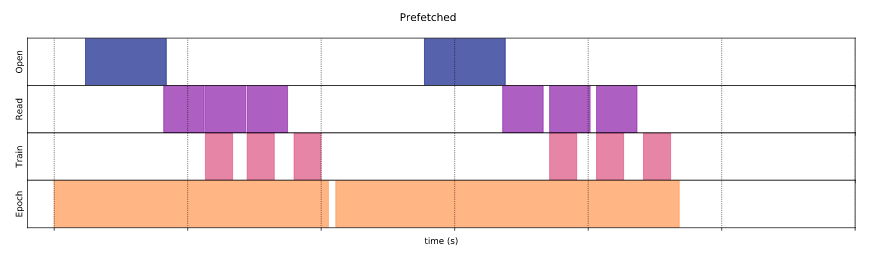

In [32]:
## Besides lets batch the data and use caching and prefetching to optimize loading speed
batch_size=32

train_ds =  train_ds.cache().batch(batch_size).prefetch(buffer_size=10) 
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Using random Data augmentation
when you dont have a large image dataset, its a good practise to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [35]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation  =  keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip('horizontal'),
     layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

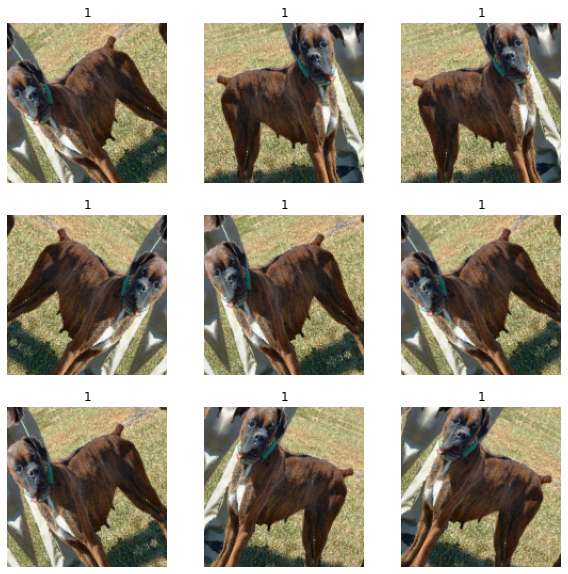

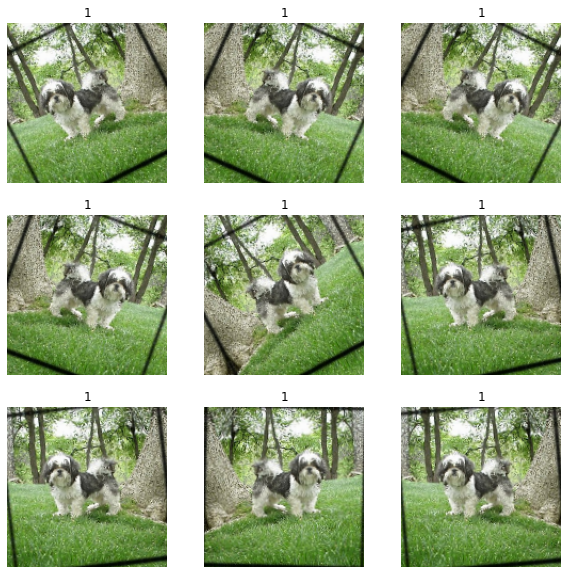

In [44]:
## Lets visualize the first images of the first batch after various random transformation

import numpy as np

for image, labels in train_ds.take(2):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    augmentated_image = data_augmentation(
        tf.expand_dims(first_image, 0), training=True
    )
    plt.imshow(augmentated_image[0].numpy().astype("int32"))
    plt.title(int(labels[0]))
    plt.axis("off")

# Step 3. Build a model

Now let's built a model that follows the blueprint we've explained earlier.

Note that:

* We add a Normalization layer to scale input values (initially in the [0, 255] range) to the [-1, 1] range.
* We add a Dropout layer before the classification layer, for regularization.
* We make sure to pass training=False when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.


In [69]:
 #input_shape: optional shape tuple, only to be specified
 #   if `include_top` is False (otherwise the input shape
 #   has to be `(299, 299, 3)`.
 #   It should have exactly 3 inputs channels,
 #   and width and height should be no smaller than 71.
 #   E.g. `(150, 150, 3)` would be one valid value

base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)
base_model.trainable= False
#base_model.summary()


In [70]:
## Create  new model on top
inputs =  keras.Input(shape=(150, 150,3))
x = data_augmentation(inputs) ## apply random data transformation

In [71]:
## Pretrained Xception weights requires that inputs to be normalized from (0,255) to range (-1,1)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([255/2.] * 3)
var = mean ** 2

## scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

In [72]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x) 
outputs  = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049

## Train the top layer

In [73]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs=20
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)
model.save("Simple_frozen_basemodel.h5")

Epoch 1/20
291/291 [==============================] - 25s 79ms/step - loss: 0.1720 - binary_accuracy: 0.9249 - val_loss: 0.0845 - val_binary_accuracy: 0.9660
Epoch 2/20
291/291 [==============================] - 23s 79ms/step - loss: 0.1202 - binary_accuracy: 0.9491 - val_loss: 0.0771 - val_binary_accuracy: 0.9699
Epoch 3/20
291/291 [==============================] - 24s 82ms/step - loss: 0.1178 - binary_accuracy: 0.9503 - val_loss: 0.0742 - val_binary_accuracy: 0.9712
Epoch 4/20
291/291 [==============================] - 24s 84ms/step - loss: 0.1147 - binary_accuracy: 0.9517 - val_loss: 0.0757 - val_binary_accuracy: 0.9690
Epoch 5/20
291/291 [==============================] - 25s 85ms/step - loss: 0.1097 - binary_accuracy: 0.9540 - val_loss: 0.0762 - val_binary_accuracy: 0.9703
Epoch 6/20
291/291 [==============================] - 24s 83ms/step - loss: 0.1093 - binary_accuracy: 0.9574 - val_loss: 0.0726 - val_binary_accuracy: 0.9716
Epoch 7/20
291/291 [==============================] 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [74]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
history_2 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)
model.save("Simple_unfrozen_basemodel.h5")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [75]:
## To plot any number of model_history for comparison
fig = plt.figure()
fig.patch.set_facecolor('white')

def plot_n_model(n=2, model_history=[],
          ylim_low=0.4, ylim_high=1.0, 
          label_list=[]    ,       
          leg_loc='lower left'):
    fig = plt.figure(figsize=(15,5))

    assert(len(model_history) ==n)
    
    variable1, variable2='accuracy','val_accuracy'
    variable3, variable4='loss', 'val_loss'
    
    color=['red','blue', 'orange', 'green', 'black', 'aqua','yellow']
    
    plt.subplot(1,2,1)
    for index, history in enumerate(model_history):
        #print(index, history)
        
        plt.plot(history.history['binary_accuracy'], label=label_list[index], c=color[index], ls='-')
        plt.plot(history.history['val_binary_accuracy'], c=color[index],ls='--')
        plt.ylabel('accuracy')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend(loc=leg_loc)
        plt.title('Training - , Validation ---')

        
    plt.subplot(1,2,2)
    for index, history in enumerate(model_history):
        plt.plot(history.history['loss'], label=label_list[index], c=color[index], ls='-')
        plt.plot(history.history['val_loss'],  c=color[index],ls='--')
        plt.title('Training - , Validation ---')

    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend(loc=leg_loc)
    plt.ylim(ylim_low,ylim_high)

<Figure size 432x288 with 0 Axes>

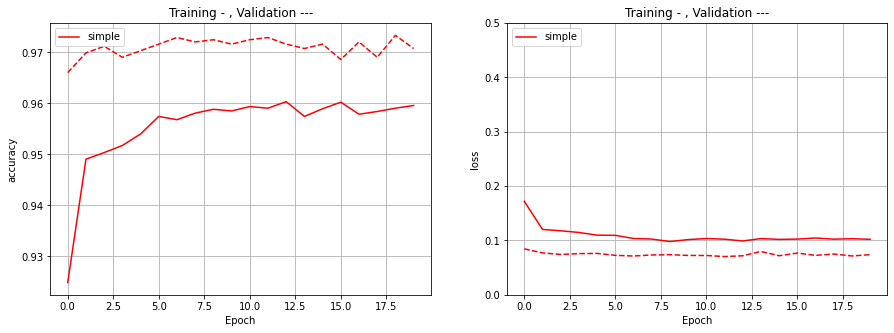

In [76]:
plot_n_model(n=1, model_history=[history], label_list=['simple'],ylim_low=0, ylim_high=0.5,leg_loc='upper left')

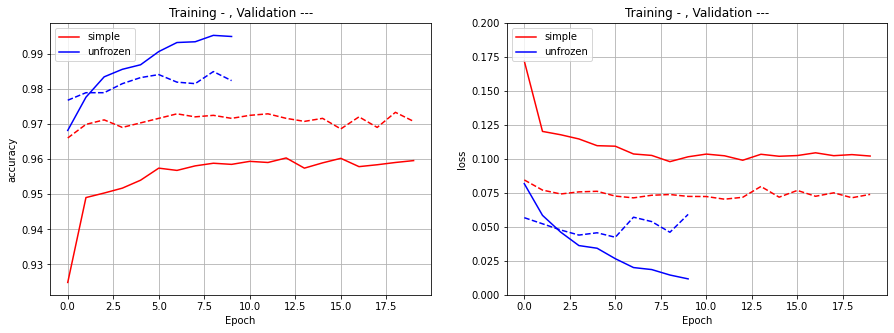

In [77]:
plot_n_model(n=2, model_history=[history, history_2], label_list=['simple', 'unfrozen'],ylim_low=0, ylim_high=0.2,leg_loc='upper left')